# Utils

This notebook contains shared functions for data preparation. This way i can reference the data without rewriting or copy pasting the functions twice.

In [4]:
# Imports
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import os
import polars as pl
import torch
import torch.nn as nn

## Data Preparation

First of all we need to properly prepare our data. Therefore I implemented a PyTorch Dataset for the data to be conveniently accessed during training and validation.

Moreover I performed some data augmentation, namely i applied:
    - random horizontal flip
    - random rotation
    - random height and width shift

I choose to not use a vertical flip, because for example in the case of baskets this would destroy the meaning of the image.
Since the images are very low resolution gray scale images I decided to not apply any additional noise and color transforms.

Stats of the data:
    - 5 classes
    - 10.000 images in training set per class (50k total)
    - 5.000 images per class in test set (25k total)
    - 28 x 28 images -> 784 features

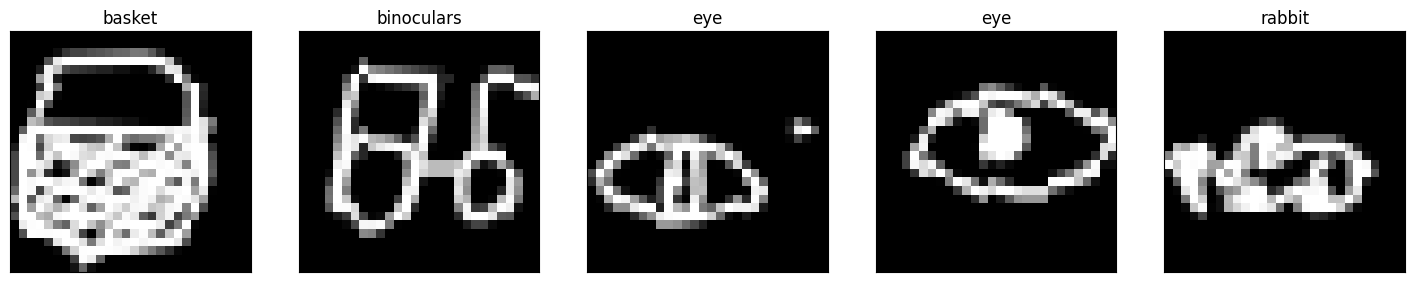

In [3]:
# data augmentation transforms
train_transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomRotation(degrees = 10),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Width and height shift
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

test_transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Classification targets & subfolder names
classes = {
    0: 'basket',
    1: 'eye',
    2: 'binoculars',
    3: 'rabbit',
    4: 'hand',
}

# Dataset class for QuickDraw
class QuickDrawDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pl.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels.row(idx)[1:]
        img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label


# Create Train and Test Datasets
train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', train_transforms)
test_data = QuickDrawDataset('../dataset/test.csv', '../dataset/images', test_transforms)

# Sample 5 random images to check if the datasets work
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(1,5 ,i+1)
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig = ax.imshow(img.squeeze(0), cmap='gray')  # Remove the channel dimension
    plt.title(classes[label])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()

## Base Module

The least for the classifier model I want to construct different model architectures and evaluate them against each other. The later code serves a common base to add an arbitrary amount of layers to.

In [5]:
class BaseModule(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential()

    def forward(self, x):
        return self.layers(x)

## Device

Initialize a common device to speed up  training if mpu or cuda acceleration is available.

In [6]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"